<a href="https://colab.research.google.com/github/densmyslov/bq-hackathon/blob/main/notebooks/1_invoice_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install tiktoken -q

In [2]:
import os
import pandas as pd
import requests
from io import BytesIO
from google.cloud import storage
import requests
import pytz
from datetime import datetime
import json
from typing import Dict, List, Any, Tuple, Optional
from collections import defaultdict

In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
from google.cloud import storage
gcs_client = storage.Client()


In [5]:
from google.cloud import bigquery
bq_client = bigquery.Client(project='data-science-455302')

In [6]:
bucket_name = "trump-political-ads"

In [7]:
table_name = 'data-science-455302.trump_campaign_us_central1.text_docs_sample'

# Invoice classification

* we will be using [AI.GENERATE_BOOL](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-ai-generate-bool) function

In [8]:
PROJECT_ID = "data-science-455302"  # your GCP project
REGION = "us-central1"              # region of your connection / dataset
DATASET_ID = "trump_campaign_us_central1"         # dataset to store the remote model
MODEL_NAME = "mistral_medium"       # name for the remote model
SOURCE_TABLE = f"{PROJECT_ID}.{DATASET_ID}.TRUMP_PDF_FILES"
CONNECTION_RESOURCE = "24627479292.us-central1.576f28e4-61cc-464a-b136-da8b005649c8"

In [9]:
table = bq_client.get_table(SOURCE_TABLE)


In [15]:
df = bq_client.list_rows(table).to_dataframe()
print(df.shape)

(298, 4)


In [ ]:
'gs://trump-political-ads-sample/FCC/docs/02d41cf6-ef29-bb8a-4133-aabf796f6d24/DONALD J TRUMP PRESIDENT 2024 WWJ INVOICE 190045389/page_1.png'

In [16]:
df.sample(1)['image_key'].tolist()

['gs://trump-political-ads-sample/FCC/docs/278ce850-7a66-7208-d171-893c6424d5c7/KSNV TRUMP 6214805 ORD/page_1.png']

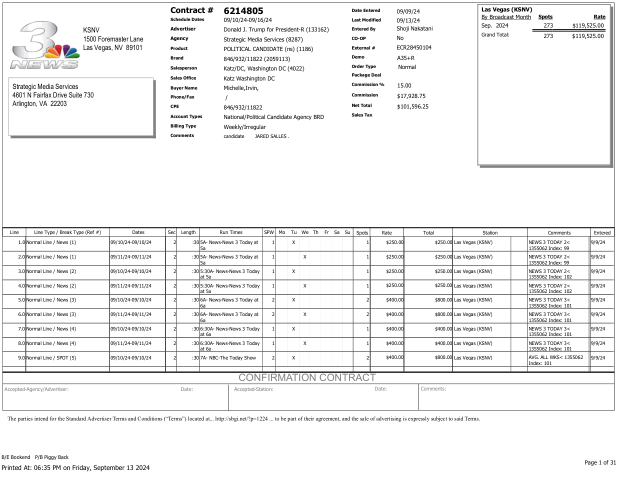

In [21]:

from PIL import Image
import io

bucket_name = "trump-political-ads-sample"
blob_path   = "FCC/docs/278ce850-7a66-7208-d171-893c6424d5c7/KSNV TRUMP 6214805 ORD/page_1.png"
bucket = gcs_client.bucket(bucket_name)
blob   = bucket.blob(blob_path)

buf = BytesIO()
blob.download_to_file(buf)
buf.seek(0)
img = Image.open(buf)
img.show()          # opens in local viewer if running desktop
display(img)

## Step 1. Use gemini-2.5-flash

### One-row smoke test

In [29]:
bq_client = bigquery.Client(project=PROJECT_ID, location=REGION)  # location can be 'US' or your dataset location
print("BQ client OK:", bq_client.project)

BQ client OK: data-science-455302


In [53]:
# ONE-ROW SMOKE TEST
sql = f"""
WITH src AS (
  SELECT
    image_key,
    REPLACE(
      REPLACE(image_key,
              'gs://trump-political-ads-sample/',
              'https://storage.googleapis.com/trump-political-ads-sample/'),
      ' ', '%20'
    ) AS url
  FROM `{SOURCE_TABLE}`
  WHERE ENDS_WITH(LOWER(image_key), '.png')
  LIMIT 1
)
SELECT
  image_key,
  (AI.GENERATE_BOOL(
     ('Is this an invoice? Answer strictly True or False.', url),
     connection_id => '{CONNECTION_RESOURCE}',   -- still required by BigQuery AI
     endpoint      => 'gemini-2.5-flash'
   )).result        AS is_invoice,
  (AI.GENERATE_BOOL(
     ('Is this an invoice? Answer strictly True or False.', url),
     connection_id => '{CONNECTION_RESOURCE}',
     endpoint      => 'gemini-2.5-flash'
   )).status        AS status,
  (AI.GENERATE_BOOL(
     ('Is this an invoice? Answer strictly True or False.', url),
     connection_id => '{CONNECTION_RESOURCE}',
     endpoint      => 'gemini-2.5-flash'
   )).full_response AS full_response
FROM src
"""
df = bq_client.query(sql).to_dataframe()


In [54]:
df

,image_key,is_invoice,status,full_response
0,gs://trump-political-ads-sample/FCC/docs/d1575...,False,,"{""candidates"":[{""avg_logprobs"":-24.57033843994..."


In [65]:
resp = df['full_response'].tolist()[0]
resp = json.loads(resp)
resp

{'candidates': [{'avg_logprobs': -24.570338439941406,
   'content': {'parts': [{'text': '{"answer": false}'}], 'role': 'model'},
   'finish_reason': 'STOP',
   'score': -122.85169219970703}],
 'create_time': '2025-09-17T09:19:58.342794Z',
 'model_version': 'gemini-2.5-flash',
 'response_id': 'Pn3KaIr2FPOThMIP5fnL8As',
 'usage_metadata': {'billable_prompt_usage': {'text_count': 402},
  'candidates_token_count': 5,
  'candidates_tokens_details': [{'modality': 'TEXT', 'token_count': 5}],
  'prompt_token_count': 251,
  'prompt_tokens_details': [{'modality': 'TEXT', 'token_count': 251}],
  'thoughts_token_count': 246,
  'total_token_count': 502,
  'traffic_type': 'ON_DEMAND'}}

In [67]:
resp['usage_metadata']

{'billable_prompt_usage': {'text_count': 402},
 'candidates_token_count': 5,
 'candidates_tokens_details': [{'modality': 'TEXT', 'token_count': 5}],
 'prompt_token_count': 251,
 'prompt_tokens_details': [{'modality': 'TEXT', 'token_count': 251}],
 'thoughts_token_count': 246,
 'total_token_count': 502,
 'traffic_type': 'ON_DEMAND'}

our "smoke test" request showed the following token usage:
* input tokens: `251+246 = 497 tokens @ $ 0.30 / mm`
* output tokens: `5 @ $ 2.5 / mm`

In [68]:
# --- 1) Classify ALL images (png/jpg/jpeg). Handles spaces; no model_params.
# Converts: gs://bucket/path -> https://storage.googleapis.com/bucket/path

DEST_TABLE   = f"{PROJECT_ID}.{DATASET_ID}.TRUMP_IMAGE_FLAGS"


sql = f"""
CREATE OR REPLACE TABLE `{DEST_TABLE}` AS
WITH src AS (
  SELECT
    image_key,
    -- Convert to public HTTPS and URL-encode spaces
    REPLACE(
      REPLACE(image_key, 'gs://', 'https://storage.googleapis.com/'),
      ' ', '%20'
    ) AS url
  FROM `{SOURCE_TABLE}`
  WHERE image_key IS NOT NULL
    AND REGEXP_CONTAINS(LOWER(image_key), r'\\.(png|jpg|jpeg)$')
)
SELECT
  image_key,
  AI.GENERATE_BOOL(
    ('Is this image an invoice? Answer strictly True or False.', url),
    connection_id => '{CONNECTION_RESOURCE}',
    endpoint      => 'gemini-2.5-flash'
  ).result AS is_invoice
FROM src
"""
bq_client.query(sql).result()
print("✅ Created:", DEST_TABLE)


✅ Created: data-science-455302.trump_campaign_us_central1.TRUMP_IMAGE_FLAGS


let's check results:

In [71]:
# --- 2) Sanity check
df = bq_client.query(f"""
SELECT
  COUNT(*) AS total,
  COUNTIF(is_invoice IS TRUE)  AS n_true,
  COUNTIF(is_invoice IS FALSE) AS n_false,
  COUNTIF(is_invoice IS NULL)  AS n_null
FROM `{DEST_TABLE}`
""").to_dataframe()
df

,total,n_true,n_false,n_null
0,298,100,198,0


In [72]:
# --- 3) (Optional) Write the flag back into your source table
# Adds a BOOL column once, then MERGEs results by image_key
bq_client.query(f"""
ALTER TABLE `{SOURCE_TABLE}`
ADD COLUMN IF NOT EXISTS is_invoice BOOL
""").result()

bq_client.query(f"""
MERGE `{SOURCE_TABLE}` T
USING `{DEST_TABLE}` R
ON T.image_key = R.image_key
WHEN MATCHED THEN
  UPDATE SET T.is_invoice = R.is_invoice
""").result()
print("✅ Backfilled is_invoice into:", SOURCE_TABLE)


✅ Backfilled is_invoice into: data-science-455302.trump_campaign_us_central1.TRUMP_PDF_FILES


In [73]:
sql = f"SELECT * FROM `{SOURCE_TABLE}`"
df = bq_client.query(sql).to_dataframe()
df.shape

(298, 5)

In [75]:
df.query("is_invoice==True")

/tmp/ipython-input-2430886783.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df.query("is_invoice==True")


,pdf_key,file_id,file_name,image_key,is_invoice
198,gs://trump-political-ads-sample/FCC/docs/75d9b...,75d9bd05-73b9-872f-d628-4bbf6b74a6a9,4637128 Donald Trump 10.17.24,gs://trump-political-ads-sample/FCC/docs/75d9b...,True
199,gs://trump-political-ads-sample/FCC/docs/4346c...,4346c01f-2971-6609-5e01-e9e8571ee40f,DONALD TRUMP FOR PRES- 4584146-1 INVOICE,gs://trump-political-ads-sample/FCC/docs/4346c...,True
200,gs://trump-political-ads-sample/FCC/docs/66258...,66258cca-52c1-a636-cc79-344eec0366d8,6193613 Invoice R-1,gs://trump-political-ads-sample/FCC/docs/66258...,True
201,gs://trump-political-ads-sample/FCC/docs/3e6f8...,3e6f8fc4-ee71-63a6-100b-571a41671b20,Donald J Trump for President 2024 est 12420 in...,gs://trump-political-ads-sample/FCC/docs/3e6f8...,True
202,gs://trump-political-ads-sample/FCC/docs/cc1f4...,cc1f40e6-884a-c531-57a4-2a2d9d92dd7b,DONALD J. TRUMP - WXLV - EST 11821 - 28450238 ...,gs://trump-political-ads-sample/FCC/docs/cc1f4...,True
...,...,...,...,...,...
293,gs://trump-political-ads-sample/FCC/docs/8206c...,8206cefa-dbc6-6ea7-18ec-8ccd39b8de3d,KVCW TRUMP 6204465 NAB,gs://trump-political-ads-sample/FCC/docs/8206c...,True
294,gs://trump-political-ads-sample/FCC/docs/13f70...,13f70763-ec76-8496-c5e2-c5509f977181,Trump - ACC 10.5,gs://trump-political-ads-sample/FCC/docs/13f70...,True
295,gs://trump-political-ads-sample/FCC/docs/551c8...,551c8e8f-fa9f-ebcb-916f-cf8c01d9908f,COMPLETE DONALD J TRUMP FOR PRESIDENT WRAZ EST...,gs://trump-political-ads-sample/FCC/docs/551c8...,True
296,gs://trump-political-ads-sample/FCC/docs/f281b...,f281bd07-fd54-b21e-7e8d-ffe2f80968ed,DONALD TRUMP FOR PRES- 4633326-1 - INVOICE,gs://trump-political-ads-sample/FCC/docs/f281b...,True
